In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose

df_train = pd.read_excel("C:\\Users\\2K\\Desktop\\train.xlsx")
df_test = pd.read_excel("C:\\Users\\2K\\Desktop\\test.xlsx")

df_train 


,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
...,...,...
395,2022-08-01,47500
396,2022-08-08,49000
397,2022-08-15,47500
398,2022-08-22,46500


In [13]:
df_train.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [14]:
#Удаление строк с пропущенными значениями
df_train_no_na = df_train.dropna()



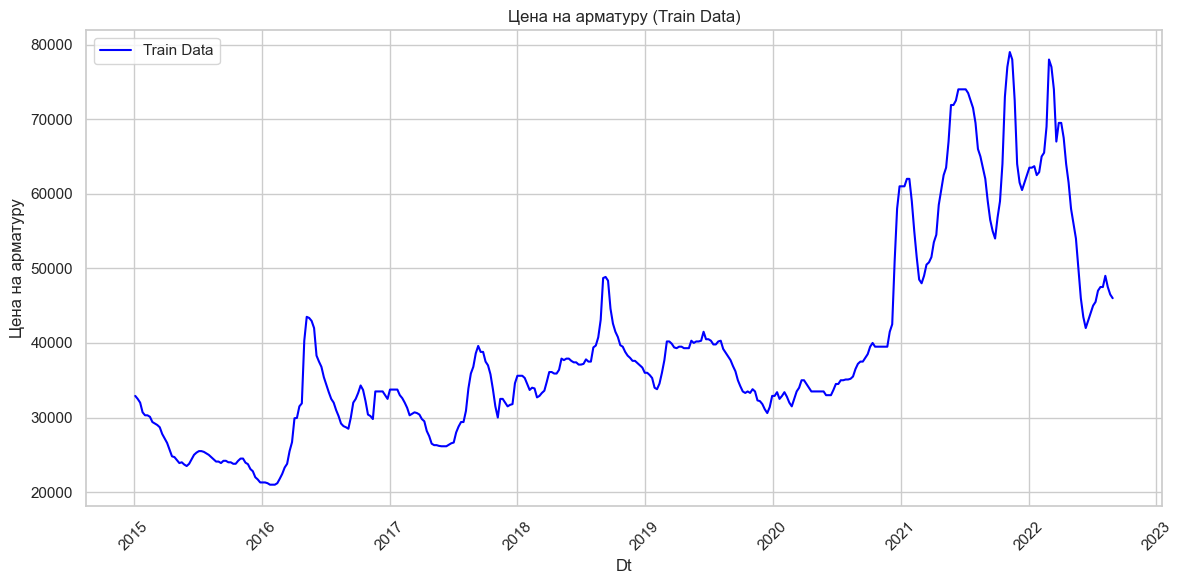

In [16]:
#  Преобразование столбца 'date' в datetime (если он еще не в этом формате)
try:
    df_train['date'] = pd.to_datetime(df_train['dt'])
except KeyError:
    print("Ошибка: Столбец 'dt' не найден. Убедитесь, что столбец с датами называется 'date'.")
    exit()

#  Настройка стиля графиков (необязательно, но улучшает внешний вид)
sns.set(style="whitegrid")

#  Визуализация цен из train.xlsx
plt.figure(figsize=(12, 6))  # Размер графика
plt.plot(df_train['dt'], df_train['Цена на арматуру'], label='Train Data', color='blue')  # Строим график
plt.xlabel('Dt')  # Подпись оси X
plt.ylabel('Цена на арматуру')  # Подпись оси Y
plt.title('Цена на арматуру (Train Data)')  # Заголовок графика
plt.legend()  # Отображение легенды
plt.xticks(rotation=45)  # Поворот подписей на оси X для читаемости
plt.tight_layout()  # Автоматическая корректировка параметров подграфика
plt.show()

Разложение временного ряда выполнено.


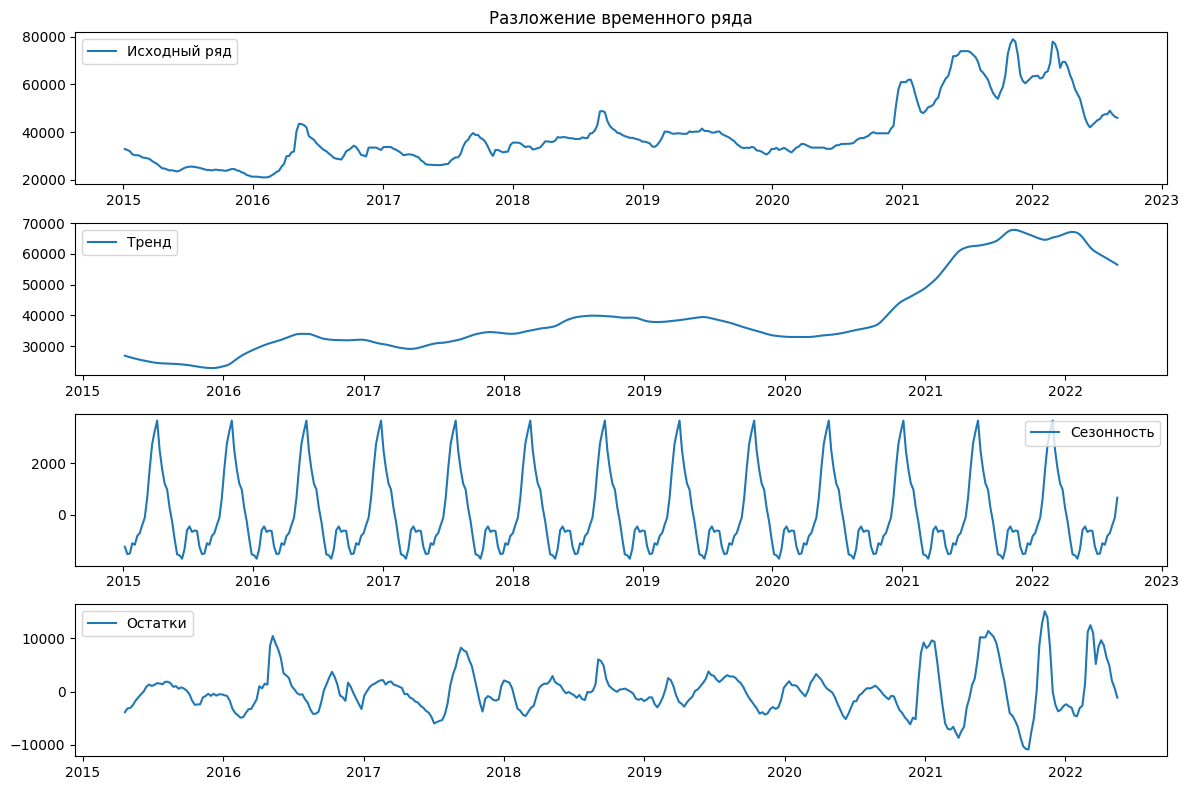

In [3]:
#Преобразование столбца 'date' в datetime (если он еще не в этом формате)
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

try:
    df_train['date'] = pd.to_datetime(df_train['dt'])
except KeyError:
    print("Ошибка: Столбец 'dt' не найден. Убедитесь, что столбец с датами называется 'date'.")
    exit()

# Установка 'date' в качестве индекса (важно для seasonal_decompose)
df_train.set_index('dt', inplace=True)

# 4. Раскладываем временной ряд
try:
    decomposition = seasonal_decompose(df_train['Цена на арматуру'], model='additive', period=30) # period - это длина сезона.  Попробуйте разные значения (например, 7, 30, 365)
    print("Разложение временного ряда выполнено.") # Добавлено для отладки
except ValueError as e:
    print(f"Ошибка при разложении временного ряда: {e}.  Возможно, недостаточно данных для выбранного period.")
    exit()

#  Визуализация компонентов
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Исходный ряд')
plt.legend()
plt.title('Разложение временного ряда')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Тренд')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Сезонность')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Остатки')
plt.legend()
plt.tight_layout()
plt.show()

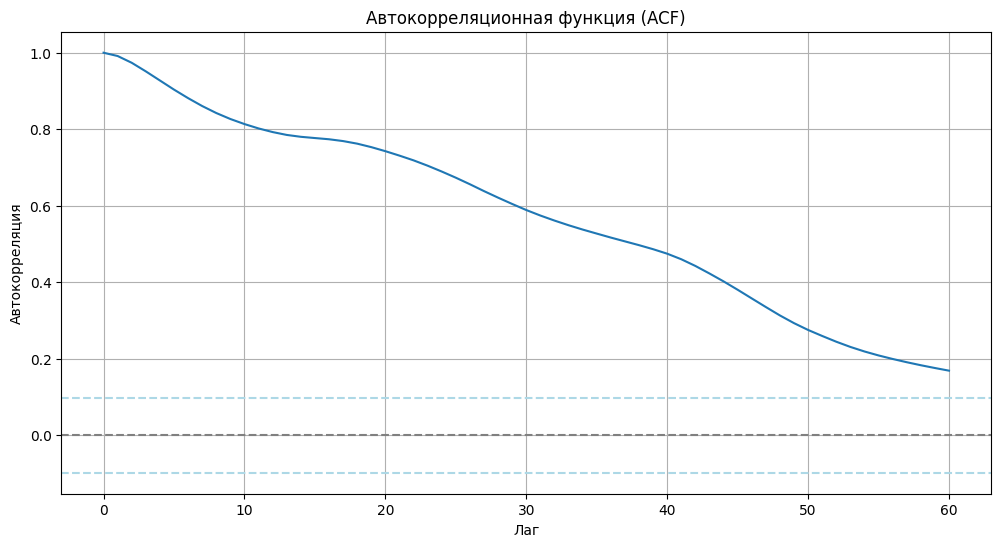

In [5]:
from statsmodels.tsa.stattools import acf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_excel("C:\\Users\\2K\\Desktop\\train.xlsx")

# Вычисление ACF
acf_values = acf(df['Цена на арматуру'], nlags=60)

# Визуализация ACF
plt.figure(figsize=(12, 6))
plt.plot(acf_values)
plt.xlabel("Лаг")
plt.ylabel("Автокорреляция")
plt.title("Автокорреляционная функция (ACF)")
plt.grid(True)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df['Цена на арматуру'])), linestyle='--', color='lightblue')
plt.axhline(y=-1.96/np.sqrt(len(df['Цена на арматуру'])), linestyle='--', color='lightblue')
plt.show()

In [33]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Загрузка данных
df_train = pd.read_excel("C:\\Users\\2K\\Desktop\\train.xlsx", parse_dates=['dt'], index_col='dt')

# 2. Разделение данных
train_size = int(len(df_train) * 0.8)
train_data, test_data = df_train[:train_size], df_train[train_size:]

# 3. Создание признаков на основе даты
train_data['year'], train_data['month'], train_data['dayofweek'] = train_data.index.year, train_data.index.month, train_data.index.dayofweek
test_data['year'], test_data['month'], test_data['dayofweek'] = test_data.index.year, test_data.index.month, test_data.index.dayofweek

# 4. Разделение на признаки и целевую переменную
X_train, y_train = train_data.drop('Цена на арматуру', axis=1), train_data['Цена на арматуру']
X_test, y_test = test_data.drop('Цена на арматуру', axis=1), test_data['Цена на арматуру']

# 5. Преобразование y в Series с временным индексом
y_train, y_test = pd.Series(y_train.values, index=train_data.index), pd.Series(y_test.values, index=test_data.index)

C:\Users\2k\AppData\Local\Temp\ipykernel_21248\2094044238.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['year'], train_data['month'], train_data['dayofweek'] = train_data.index.year, train_data.index.month, train_data.index.dayofweek
C:\Users\2k\AppData\Local\Temp\ipykernel_21248\2094044238.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['year'], train_data['month'], train_data['dayofweek'] = train_data.index.year, train_data.index.month, train_data.index.dayofweek
C:\Users

In [34]:
import pandas as pd, numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# 1. Параметры и обучение
order = (5, 1, 0) # (AR, I, MA)
try:
    model_fit = ARIMA(y_train, order=order).fit()
    print(model_fit.summary())

    # 2. Прогнозирование и оценка
    y_pred = model_fit.predict(start=y_test.index[0], end=y_test.index[-1])
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE: {rmse}')

except Exception as e:
    print(f"Ошибка ARIMA: {e}")
    y_pred = pd.Series(np.nan, index=y_test.index)

C:\Users\2k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\2k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\2k\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  320
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2703.625
Date:                Wed, 19 Mar 2025   AIC                           5419.250
Time:                        22:56:13   BIC                           5441.841
Sample:                    01-05-2015   HQIC                          5428.272
                         - 02-15-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3040      0.015     19.985      0.000       0.274       0.334
ar.L2          0.0613      0.039      1.582      0.114      -0.015       0.137
ar.L3         -0.0961      0.052     -1.842      0.0

MSE: 214637657.04, MAE: 12266.32


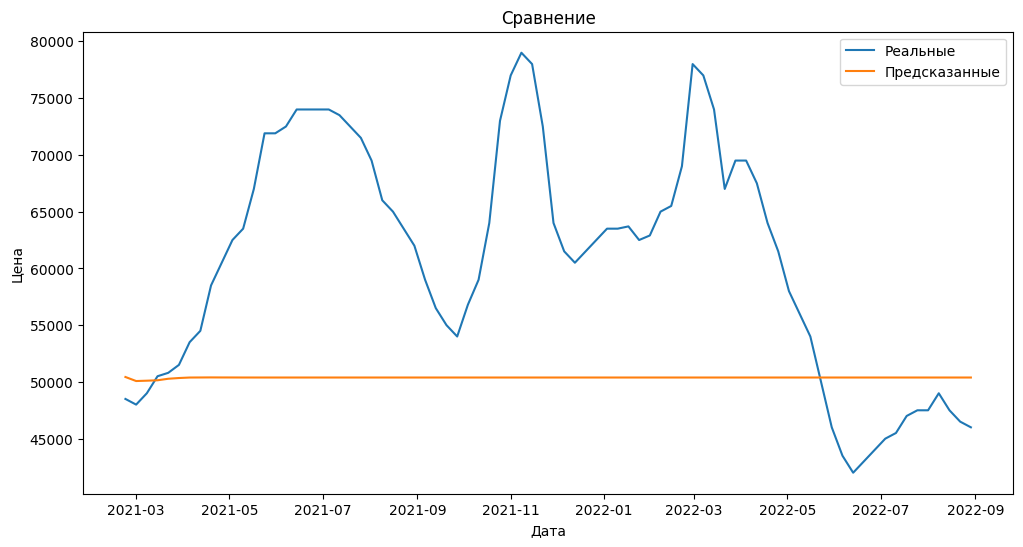

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Оценка модели
mse, mae = mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse:.2f}, MAE: {mae:.2f}')

# Визуализация предсказанных и реальных значений
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Реальные')  # Используем индекс y_test
plt.plot(y_pred.index, y_pred, label='Предсказанные')  # Используем индекс y_pred
plt.title('Сравнение')
plt.xlabel('Дата'); plt.ylabel('Цена')
plt.legend(); plt.show()